In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time 

In [ ]:
batch_size = 64
epochCount = 20
learningRate = 0.0005

In [ ]:
batchrow = int(batch_size / 8)

In [ ]:
dataset_0 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

dataloader = torch.utils.data.DataLoader(dataset_0, batch_size=10, num_workers=2, shuffle=False)

mean = 0.
std = 0.

for i, data in enumerate(dataloader, 0):
    img, lbl = data
    batchSize = img.size(0)
    img = img.view(batchSize, img.size(1), -1)
    mean += img.mean(2).sum(0)
    std += img.std(2).sum(0)
  
mean /= len(dataset_0)
std /= len(dataset_0)
print(mean, std)

tensor([0.1307]) tensor([0.3015])


In [ ]:
transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307),(0.3015))])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)

trainset, valset = torch.utils.data.random_split(dataset, [50000, 10000])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=int(batch_size / 5), shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')



In [ ]:
#@title Under construction
#under construction
"""
exp_labels_list = []
for i in range(100):
  _,label = trainset[i]
  exp_labels_list.append(label)
print(exp_labels_list)
trainset.targets

In [ ]:
#@title Under construction
#under construction, code for dataset splitter with equal distribtuion of classes
"""
eqsplitloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False,num_workers=2)

clinp_list = [] # list of lists, containing images sorted by classes
cltgt_list = [] # list of lists, containing labels for images
cl_count = len(classes)
flag = 0 #constatnt to flag if the image of this class was already sorted
inp_list = []
tgt_list = []

for i in range(cl_count):
  empty_list = []
  clinp_list.append(empty_list)
  cltgt_list.append(empty_list)

for i, data in enumerate(eqsplitloader, 0):
  inp, tgt = data
  inp_list.append(inp)
  tgt_list.append(tgt)

print(inp_list[0])
print(tgt_list[0])


  emptycl_idx = 0 #index of first empty list in list of lists
  clinp_list[emptycl_idx].append(inp[0]) #sorting the first image and its label
  cltgt_list[emptycl_idx].append(tgt[0])
  for k in range(i): #running check

    if tgt[i] == tgt[k]:
      flag = 1
      break
  if flag == 1: #if there is list for class of next item in dataloader
    for j in range(cl_count): 
          if tgt[i] != cltgt_list[j][0]: #find it
            continue
          else:
            clinp_list[j].append(inp[i]) #store it and its label
            cltgt_list[j].append(tgt[i])
            break
  else: #if loaded image is of new class
    emptycl_idx += 1 #move index of first empty list
    clinp_list[emptycl_idx].append(inp[i]) #store the imge and its label
    cltgt_list[emptycl_idx].append(tgt[i])
"""
  




In [ ]:
print(len(trainset))
print(len(valset))
print(len(testset))
epoch_count_train = int(len(trainset) / batch_size)
epoch_count_val = int(5 * len(valset) / batch_size)
print(epoch_count_train)
print(epoch_count_val)

50000
10000
10000
781
781


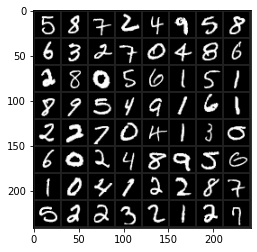

    5     8     7     2     4     9     5     8

    6     3     2     7     0     4     8     6

    2     8     0     5     6     1     5     1

    8     9     5     4     9     1     6     1

    2     2     7     0     4     1     3     0

    6     0     2     4     8     9     5     6

    1     0     4     1     2     2     8     7

    5     2     2     3     2     1     2     7



In [ ]:
def showimg(image):
  image = image * 0.3015 + 0.1307
  npimage = image.numpy()
  plt.imshow(np.transpose(npimage, (1, 2, 0)))
  plt.show()

dataiter_train = iter(trainloader)
images, labels = dataiter_train.next()

showimg(torchvision.utils.make_grid(images))
for k in range(batchrow):
  print(' '.join('%5s' % classes[labels[j]] for j in range(k * 8, (k + 1) * 8)), end='\n\n')
  k += 1

In [ ]:
class skynet1(nn.Module):
  def __init__(self):
    super(skynet1, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3) #1 input channel, 8 output channels(number of filters), 3x3 kernel, stride 1, no padding
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.pool1 = nn.MaxPool2d(2, 2, 1) #2x2 filter, stride 2, padding 1
    self.conv2 = nn.Conv2d(8, 16, 3) 
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(16, 128, 6)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.fc1 = nn.Linear(128, 64)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.fc2 = nn.Linear(64, 10)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    #self.dropout1 = nn.Dropout(0.1)
    #self.dropout2 = nn.Dropout(0.5)
    
  def forward(self, x):
    #x = self.dropout1(x)
    x = F.relu(self.conv1(x))
    #x = self.dropout1(x)
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    #x = self.dropout1(x)
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    #x = self.dropout1(x)
    x = x.view(-1, 128)
    x = self.fc1(x)
    #x = self.dropout2(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

net = skynet1()


In [ ]:
params = list(net.parameters())
print(len(params))
for i in range(10):
  print(params[i].size())

10
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([128, 16, 6, 6])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr = learningRate, betas = (0.9,0.999), eps = 1e-6)

In [ ]:
tloss_plt = []
epoch_tloss_plt = []
train_acc_plot = []
correct_train = 0.0
total_train = 0.0

vloss_plt = []
epoch_vloss_plt = []
val_acc_plot = []
correct_val = 0.0
total_val = 0.0


for epoch in range(epochCount):

    running_tloss = 0.0
    running_vloss = 0.0
    avg_perbatch_acc_train = 0.0
    avg_perbatch_acc_val = 0.0
    start = time.time()

    print('epoch', epoch + 1)

    net.train(mode=True)
    print('training cycle')
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      perbatch_acc_train = 0.0
      _, predicted_train = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted_train == labels).sum().item()
      perbatch_acc_train = correct_train / total_train
      avg_perbatch_acc_train += perbatch_acc_train / 2

      running_tloss += loss.item()

      if i % 50 == 49:
         tloss_plt.append(loss.item())
         
      if i % 200 == 199:
        print('[%d, %5d] train loss: %.6f, avg_train_acc: %.2f %%' % (epoch + 1, i + 1, running_tloss / 200, avg_perbatch_acc_train))
        train_acc_plot.append(avg_perbatch_acc_train)
        running_tloss = 0.0
        avg_perbatch_acc_train = 0.0

    net.train(mode=False)
    print('evaluation cycle')
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        perbatch_acc_val = 0.0
        _, predicted_val = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val == labels).sum().item()
        perbatch_acc_val = correct_val / total_val
        avg_perbatch_acc_val += perbatch_acc_val / 2

        running_vloss += loss.item()

        if i % 50 == 49:
         vloss_plt.append(loss.item())
         
        if i % 200 == 199:
          print('[%d, %5d] val loss: %.6f, avg_val_acc: %.2f %%' % (epoch + 1, i + 1, running_vloss / 200, avg_perbatch_acc_val))
          val_acc_plot.append(avg_perbatch_acc_val)
          running_vloss = 0.0
          avg_perbatch_acc_val = 0.0

    epoch_tloss_plt.append(running_tloss / epoch_count_train)
    epoch_vloss_plt.append(running_vloss / epoch_count_val)
    end = time.time()
    print('time spent on epoch %d: %.2f s' % (epoch + 1,end - start))
print('sector clear!')

epoch 1
training cycle
[1,   200] train loss: 0.002859, avg_train_acc: 99.91 %


KeyboardInterrupt: ignored

Text(0, 0.5, 'loss')

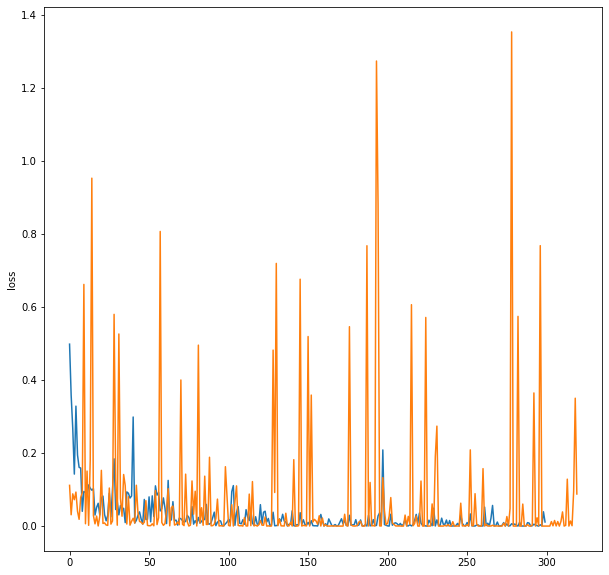

In [ ]:
print(len(tloss_plt))
print(len(vloss_plt))
plt.figure(figsize=[10, 10])
plt.plot(tloss_plt)
plt.plot(vloss_plt)
plt.ylabel('loss')

Text(0, 0.5, 'loss')

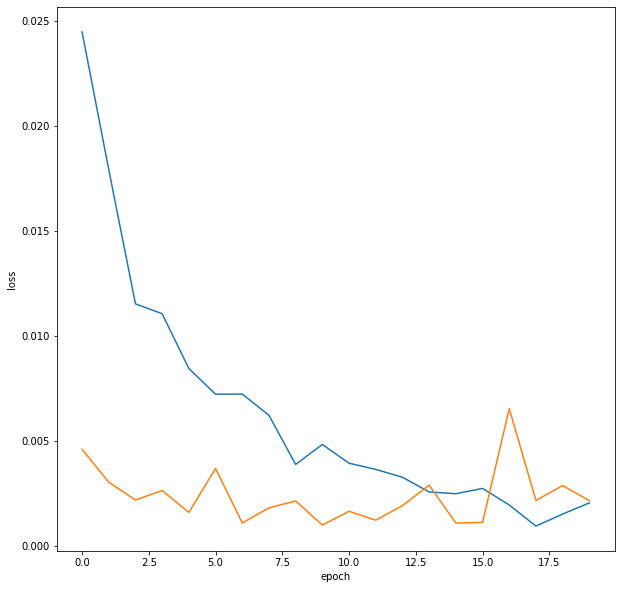

In [ ]:
plt.figure(figsize=[10, 10])
plt.plot(epoch_tloss_plt)
plt.plot(epoch_vloss_plt)
plt.xlabel('epoch')
plt.ylabel('loss')

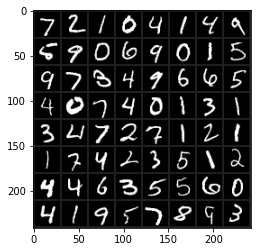

ground truth labels:
    7     2     1     0     4     1     4     9

    5     9     0     6     9     0     1     5

    9     7     3     4     9     6     6     5

    4     0     7     4     0     1     3     1

    3     4     7     2     7     1     2     1

    1     7     4     2     3     5     1     2

    4     4     6     3     5     5     6     0

    4     1     9     5     7     8     9     3

predicted:
    7     2     1     0     4     1     4     9

    5     9     0     6     9     0     1     5

    9     7     8     4     9     6     6     5

    4     0     7     4     0     1     3     1

    3     4     7     2     7     1     2     1

    1     7     4     2     3     5     1     2

    4     4     6     3     5     5     6     0

    4     1     9     5     7     8     9     3



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

showimg(torchvision.utils.make_grid(images))
print('ground truth labels:')
for k in range(batchrow):
  print(' '.join('%5s' % classes[labels[j]] for j in range(k * 8, (k + 1) * 8)),end='\n\n')
  k += 1

outputs = net(images)

_,predicted = torch.max(outputs, 1)
print('predicted:')
for k in range(batchrow):
  print(' '.join('%5s' % classes[predicted[j]] for j in range(k * 8, (k + 1) * 8)),end='\n\n')
  k += 1

In [ ]:
loss_test_plt = []
correct_test = 0
total_test = 0
test_acc_plot = []
avg_test_acc = 0.0
avg_loss_test = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()
        avg_test_acc = 100 * correct_test / total_test
        test_acc_plot.append(avg_test_acc)

print('accuracy %.2f %%, error rate %.2f %%' % (avg_test_acc, 100 - avg_test_acc))

accuracy 98.80 %, error rate 1.20 %


Text(0, 0.5, 'accuracy,%')

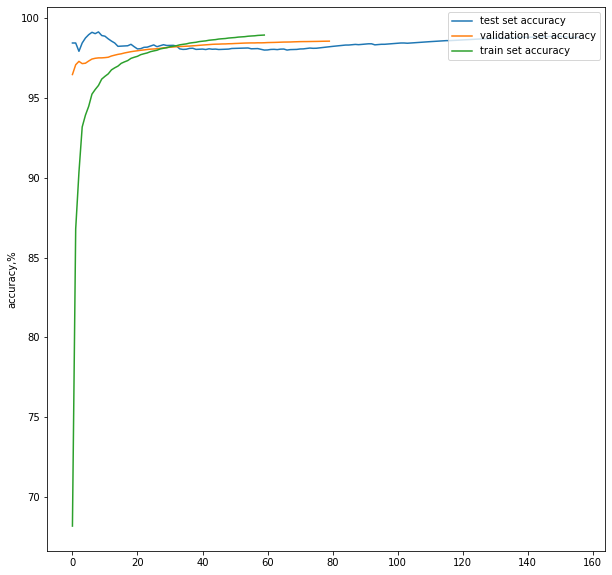

In [ ]:
print(len(train_acc_plot),len(val_acc_plot),len(test_acc_plot))
plt.figure(figsize=[10, 10])
plt.plot(test_acc_plot,label='test set accuracy')
plt.plot(val_acc_plot,label='validation set accuracy')
plt.plot(train_acc_plot,label='train set accuracy')
plt.legend(loc='upper right')
plt.ylabel('accuracy,%')

version-batchsize-epochnum-lr-dropout-error

1-64-60-0.0005-no-1.19%

2-64-30-0.0005-no-1.06%

3-32-30-0.0005-no-1.02%

4-32-30-0.0005-fc1,fc2-40.78%

5-64-15-0.005-fc1,fc2-40.30%

6-64-15-0.005-fc1-1.66%

7-64-15-0.05-fc1-43.58%

8-128-15-0.0005-fc1-1.39%

9-64-15-0.0005-init-1.07%

10-32-15-0.0005-init-1.10%

11-64-15-0.0005-init,fc1-1.49%

12-64-15-0.0005-init,fc1,fc2(0.1)-5.26%

12-64-15-0.0005-init,conv1,conv2,conv3-1.33%

12-64-50-0.0001-init-1.27%